# Spanish Translation A/B Test

Company XYZ is a worldwide e-ecommerce site with localized versions of the site. It was observed that Spain based users have
a much higher conversion rate than any other Spanish speaking country. One of the possible reasons could be poor translation.
However, it was noticed that all Spanish speaking countries had the same translation as that of the Spain based site written by a Spaniard. Hence, it was agreed upon to conduct an A/B test, where two versions of the site would be released. One of these versions would be written by a local translator from the native country and the other would be the original site written by the Spaniard.

After running the test for five days, the results turned out to be negative. This implies, the local translation did poorly as compared to the original translation. 

The following analysis is to investigate, if the test was actually negative and if so, the possible reasons for it.

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series 
from matplotlib import pyplot as plt 
import matplotlib.ticker as ticker
import scipy as sc
from scipy import stats 
import sklearn
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Imputer
from StringIO import StringIO
from inspect import getmembers

In [2]:
%matplotlib inline

Reading in the data

In [3]:
test_table = pd.read_csv('test_table.csv')
user_table = pd.read_csv('user_table.csv')

In [4]:
test_table.head(5)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [5]:
user_table.head(5)

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


Merging the two datasets by checking for unique id's

In [6]:
len(test_table) == len(test_table['user_id'].unique())

True

In [7]:
len(user_table) == len(user_table['user_id'].unique())

True

Comparing the lengths of both the tables

In [8]:
test_table.shape

(453321, 9)

In [9]:
user_table.shape

(452867, 4)

This implies the user_table is missing a few id's.
Therefore when we perform a join operation, we shouldn't loose the user id's in the test table that are not in the user table.

We could either do a left join or an outer join. Going with the outer join in the following case

In [10]:
data = pd.merge(test_table, user_table, on = 'user_id', how = 'outer')
data.head(5)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [11]:
data.shape

(453321, 12)

Summarizing the data. Getting the basic descriptive statistics.

In [12]:
data.describe()

,user_id,conversion,test,age
count,453321.000000,453321.000000,453321.000000,452867.000000
mean,499937.514728,0.049579,0.476446,27.130740
std,288665.193436,0.217073,0.499445,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249816.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749522.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


#### Some insights from the data so far. 

1. Average conversion rate is roughly 4%. This is pretty normal. Considered to be industry standard.
2. 47% of the population belong in the test group and 53% in the control group
3. This is a fairly young user base with a mean age of 27 years. Also 75% of the user base is within 30 years of age. 

Understanding if Spain actually converts best, as compared to other Spanish speaking nations

In [13]:
data.groupby('country')[['conversion']].mean()

,conversion
country,
Argentina,0.013994
Bolivia,0.048634
Chile,0.049704
Colombia,0.051332
Costa Rica,0.053494
Ecuador,0.049072
El Salvador,0.050765
Guatemala,0.049653
Honduras,0.049253


From the above results, it is quite evident that spain has a conversion rate of nearly 7.9% whereas other nations have conversion rates in the range of 4-5%. Therefore, Spain indeed has the best conversion rate. 

Below is the comparison of the performance in test and control groups. It can be seen that the control group did much better than the test group.

In [14]:
data.groupby('test')[['conversion']].mean()

,conversion
test,
0,0.055179
1,0.043425


Below is the comparison of the test and control group without Spain in the picture

In [15]:
data_new =data.copy()
data_new = data_new[data_new['country']!= 'Spain']
data_new.head(5)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico
5,540675,2015-12-03,Direct,Mobile,ES,NaN,Android_App,0,1,F,22.0,Venezuela
6,863394,2015-12-04,SEO,Mobile,Other,NaN,Android_App,0,0,M,35.0,Mexico


In [16]:
data_new.groupby('test')[['conversion']].mean()

,conversion
test,
0,0.048330
1,0.043425


#### Some quick insights

1. From the results it is quite evident that both the control group and the test group are faring similarly with the control group performing slightly better.

2. There happened to be more spaniards in the control group as compared to the test group. As their conversion rate was higher, the control group had a higher mean. However, removing them as caused both the control and test group to perform similarly

3. Secondly, for other countries other than spain, it doesn't seem to matter whether the translation is by a local or by a spaniard. The test results are more or less the same

Doing a welch two sample t test on both the groups to check if there is a statistical difference in the mean of the two groups

In [17]:
zero = data_new[data_new['test'] == 0]
one = data_new[data_new['test'] == 1]

sc.stats.ttest_ind(zero['conversion'], one['conversion'], equal_var = False, axis = 0)

Ttest_indResult(statistic=7.3939374121344805, pvalue=1.4282994754055316e-13)

#### Insights

As the p value is less than alpha = .05, we can reject the null hypothesis.
This implies, we can tell with statistical significance that the two groups have different means.
Mean of test = 4.3% and mean of control = 4.8%.
This would be a significant difference in means, if it were true

Likely reasons for this include

1. Control group and test group are not really random
2. Not enough data for the sample to truly represent the population

Converting data to standard format. This includes formatting datetime column

In [18]:
data_new['date'] = pd.to_datetime(data_new['date'], infer_datetime_format = True)

Plotting to check for any anomalies or biases

In [19]:
time_series = data_new.groupby(['date','test'])[['conversion']].mean()
time_series

conversion
date       test            
2015-11-30 0       0.051378
           1       0.043886
2015-12-01 0       0.046287
           1       0.041387
2015-12-02 0       0.048550
           1       0.044234
2015-12-03 0       0.049284
           1       0.043884
2015-12-04 0       0.047043
           1       0.043491

In [20]:
time_series = time_series.unstack()['conversion'][1]/time_series.unstack()['conversion'][0]
time_series

date
2015-11-30    0.854179
2015-12-01    0.894141
2015-12-02    0.911090
2015-12-03    0.890439
2015-12-04    0.924486
dtype: float64

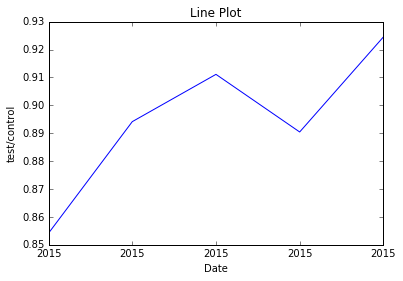

In [21]:
fig, ax = plt.subplots(1,1)
ax.plot(time_series)
ax.set_xlabel('Date')
ax.set_ylabel('test/control')
ax.set_title('Line Plot')

ax.xaxis.set_major_locator(ticker.MultipleLocator())

#### Insights

From the above graph it can be seen that over the course of five days, control does continuously better than test.
Also the variability in the test/control variable is low. Min = 0.87 and Max = 0.93.
This implies that data collected is sufficient, however there might be a bias in the control or test group.

Likely cause

1. Some segment of the data that has a higher or lower conversion rate has found it's way into either test or control thus increasing/decreasing that groups' overall conversion rate.

2. We can use decision trees to identify this. If the split between test and control is truly random, then the tree shouldn't be able to split well.

In [22]:
X = data_new.copy()
lb = LabelEncoder()
X['source'] = lb.fit_transform(X['source'])
X['country'] = lb.fit_transform(X['country'])
X['device'] = lb.fit_transform(X['device'])
X['browser_language'] = lb.fit_transform(X['browser_language'])
X['ads_channel'] = lb.fit_transform(X['ads_channel'])
X['browser'] = lb.fit_transform(X['browser'])
X['sex'] = lb.fit_transform(X['sex'])
X = X.drop(['conversion','date','test'], axis = 1)
y = data_new['test']
X.head(5)

C:\Users\Deepak\Anaconda2\lib\site-packages\numpy\lib\arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


,user_id,source,device,browser_language,ads_channel,browser,sex,age,country
1,497851,0,1,1,3,3,2,21.0,10
3,290051,0,0,2,2,0,1,22.0,10
4,548435,0,1,1,3,2,2,19.0,10
5,540675,1,0,1,0,0,1,22.0,16
6,863394,2,0,2,0,0,2,35.0,10


In [23]:
#Checking for missing values
X.isnull().sum()

user_id               0
source                0
device                0
browser_language      0
ads_channel           0
browser               0
sex                   0
age                 454
country               0
dtype: int64

In [24]:
#Index values of all NAN's
index = X['age'].index[X['age'].apply(np.isnan)]
index

Int64Index([   819,   1696,   1934,   2409,   2721,   5042,   7552,   7855,
              8930,   9082,
            ...
            444098, 444581, 444828, 445540, 445950, 446681, 451052, 452302,
            452342, 453270],
           dtype='int64', length=454)

Below, imputing the missing values in age column with median age of the column

In [25]:
impute = Imputer(missing_values = 'NaN', strategy = 'median', axis = 0, copy = True)
imputed = DataFrame(impute.fit_transform(X))
imputed.columns = X.columns.values
imputed.head(5)

,user_id,source,device,browser_language,ads_channel,browser,sex,age,country
0,497851.0,0.0,1.0,1.0,3.0,3.0,2.0,21.0,10.0
1,290051.0,0.0,0.0,2.0,2.0,0.0,1.0,22.0,10.0
2,548435.0,0.0,1.0,1.0,3.0,2.0,2.0,19.0,10.0
3,540675.0,1.0,0.0,1.0,0.0,0.0,1.0,22.0,16.0
4,863394.0,2.0,0.0,2.0,0.0,0.0,2.0,35.0,10.0


Creating an instance of the Decision tree classifier below

In [26]:
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 2, min_samples_leaf = 2, min_samples_split = 2)

In [27]:
clf.fit(imputed,y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Understanding the most important features from the classification

In [28]:
clf.feature_importances_

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])

In [29]:
imputed.columns.values

array(['user_id', 'source', 'device', 'browser_language', 'ads_channel',
       'browser', 'sex', 'age', 'country'], dtype=object)

#### Insights

There seems to be a fair amount of bias in the way control and test groups are separated. 
This is highlighted by the feature importance variable. 
Country seems to be an important feature when it comes to separating test and control groups.
Therefore, the separation is not truly random

In [30]:
zip(imputed.columns[clf.tree_.feature], clf.tree_.threshold, clf.tree_.children_left, clf.tree_.children_right)

[('country', 1.5, 1, 4),
 ('country', 0.5, 2, 3),
 ('age', -2.0, -1, -1),
 ('age', -2.0, -1, -1),
 ('country', 14.5, 5, 6),
 ('age', -2.0, -1, -1),
 ('age', -2.0, -1, -1)]

In [31]:
clf.tree_.children_left

array([ 1,  2, -1, -1,  5, -1, -1], dtype=int64)

In [32]:
imputed['country'].unique()

array([ 10.,  16.,   2.,   4.,  15.,   7.,  11.,  14.,   5.,   3.,   1.,
         6.,   8.,   9.,  13.,  12.,   0.])

In [33]:
data_new['country'].unique()

array(['Mexico', 'Venezuela', 'Bolivia', 'Colombia', 'Uruguay',
       'El Salvador', 'Nicaragua', 'Peru', 'Costa Rica', 'Chile',
       'Argentina', 'Ecuador', 'Guatemala', 'Honduras', 'Paraguay',
       'Panama', nan], dtype=object)

In [34]:
a = data_new.groupby(['country','test'])[['conversion']].mean().unstack()
b = data_new.groupby('country')[['test']].mean()
df = pd.concat([a,b], axis = 1)

temp1 = data_new[data_new['test'] == 0]
temp2 = data_new[data_new['test'] == 1]

a = []; b = []; c = []; d = []

for i, j in temp1.groupby('country')['conversion']:
    a.append(i)
    b.append(j)
for i, j in temp2.groupby('country')['conversion']:
    c.append(i)
    d.append(j)
    
p_value = []
for i in np.arange(16):
    p_value.append(sc.stats.ttest_ind(b[i], d[i], equal_var = False, axis = 0)[1])    
    
df = pd.concat([df, DataFrame(p_value, index = a)], axis = 1)

df.columns = ['mean in control', 'mean in test', '%samples in test group', 'p_value']
df

,mean in control,mean in test,%samples in test group,p_value
country,,,,
Argentina,0.015071,0.013725,0.799799,0.335147
Bolivia,0.049369,0.047901,0.501079,0.718885
Chile,0.048107,0.051295,0.500785,0.302848
Colombia,0.052089,0.050571,0.498927,0.423719
Costa Rica,0.052256,0.054738,0.498964,0.687876
Ecuador,0.049154,0.048988,0.494432,0.961512
El Salvador,0.053554,0.047947,0.497492,0.248127
Guatemala,0.050643,0.048647,0.496066,0.572107
Honduras,0.050906,0.047540,0.491013,0.471463


#### Conclusions

As it can be seen the p-value associated with all the countries is much greater than 0.05

This implies that we fail to reject the null hypothesis. Thus, there is no statistically significant difference in means
between test and control group in each country. 

However, as it can be seen Argentina and Uruguay have the lowest conversion rate of 1%. Also, nearly 80% of the samples from 
these two countries found it's way into the test group and only 20% in the control group.This can be verified from the 
third column in the above dataframe. 

Due to their small conversion rate and massive influx of samples into the test group, there was a significant difference
between the overall test conversion and control conversion rates. It was because of this the mean of the test group was much
less than the mean of the control group.

However, it is now clear that the A/B test was insignificant. Both the test and the control group perform similarly. 
It is clear that the local translation did not affect the conversion rate.

Side Note

1. Argentina and Uruguay have the lowest conversion rate
2. Marketing efforts can be directed in this direction to improve conversion rate in these two countries